<a href="https://colab.research.google.com/github/mamathasara/AICTE-Internship---E-Waste-Generation-Classification-/blob/main/Week3_Updated_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**E-Waste Generation Classification using MobileNetV3**


In my e-waste image classification project, I considered switching from EfficientNetV2 to MobileNetV3 because MobileNetV3 offers a better balance between speed and accuracy for small to medium-sized datasets like mine. While EfficientNetV2 is highly accurate, it is also computationally heavier and takes more time and resources to train. On the other hand, MobileNetV3 is lightweight, faster to train, and better suited for limited hardware like Google Colab or systems without high-end GPUs. It allows quicker testing and deployment, which is especially helpful when working on assignments or building web-based demos. Since my project involves around 2400 images and doesn’t require extremely high precision, MobileNetV3 is a more practical and efficient choice that still delivers strong performance with much better speed.


In [1]:
# Install TensorFlow package
!pip install tensorflow

I am sticking to TensorFlow in my e-waste classification project because it strikes the best balance between simplicity, power, and deployment readiness. Compared to PyTorch, TensorFlow—especially with Keras—offers a more beginner-friendly interface, allowing me to build and train deep learning models with less code and confusion. While PyTorch is very popular in research due to its flexibility and dynamic graph system, TensorFlow excels in providing pre-trained models (like EfficientNet and MobileNet), integration with tools like Gradio, and easy deployment options such as TensorFlow Lite for mobile or TensorFlow.js for web. Other libraries like Scikit-learn or CNTK are not well-suited for deep image classification tasks and lack the modern features needed for this kind of project. Since I am still learning and my goal is to complete an efficient and accurate image classifier with the option to deploy a working demo, TensorFlow is the most practical and powerful choice for my current needs.

In [2]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [3]:
# 📦 Core ML Framework
import tensorflow as tf

# 🧱 Model Building & Layers
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# 🚀 Pre-trained Model for Transfer Learning (Faster & Lighter)
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# ✅ Optimizer (correct path for AdamW in TF 2.18)
from tensorflow.keras.optimizers import AdamW

# 🔢 Array and Math Operations
import numpy as np

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# 🌐 Simple Web Interface for Demo
import gradio as gr

# 🖼️ Image Handling
from PIL import Image


**✅ Changes Made in the Import Section with Reasons**

**🔁 Replaced EfficientNetV2B0 ➝ MobileNetV3Large**

🔹 Why: MobileNetV3 is lighter, faster, and still provides good accuracy — ideal for small to medium image datasets like yours.

🔹 Goal: Faster training and better runtime performance.

**✅ Replaced Sequential model with Functional API (Input, Model)**

🔹 Why: Functional API gives more flexibility to build and customize complex models (especially helpful for transfer learning).

🔹 Goal: Professional, scalable model architecture.

**✅ Added BatchNormalization import**

🔹 Why: Helps the model train faster and more stably by normalizing layer outputs.

🔹 Goal: Boost accuracy and prevent overfitting.

**🔁 Replaced standard Adam ➝ AdamW from tensorflow.keras.optimizers.experimental**

🔹 Why: AdamW adds weight decay, which helps reduce overfitting and improves generalization.

🔹 Goal: Improve accuracy without increasing complexity.

**✅ Changed preprocessing to use mobilenet_v3.preprocess_input**

🔹 Why: Preprocessing must match the model architecture (MobileNetV3 expects its own format).

🔹 Goal: Ensure images are prepared correctly for MobileNetV3.

**✅ Kept Gradio for deployment**

🔹 Why: Still the best choice for a quick, interactive UI demo.

🔹 Goal: Easily test and showcase predictions.

**✅ Used GlobalAveragePooling2D**

🔹 Why: Flattens the feature maps without using too many parameters, reducing overfitting.

🔹 Goal: Maintain performance with fewer parameters.

**✅ Kept PIL, matplotlib, seaborn, numpy, and sklearn.metrics**

PIL – Loads and processes uploaded image files for prediction.

matplotlib.pyplot – Plots training/validation accuracy and loss curves.

seaborn – Creates clean confusion matrix heatmaps for evaluation.

numpy – Handles arrays and numerical operations for image and model data.

sklearn.metrics – Provides classification metrics like accuracy, precision, and confusion matrix.

**Format: Folder-based image classification dataset**

Train/: Images used for training the model

Test/: Images used for model evaluation

Validation/: Images used to fine-tune and validate the model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
trainpath = "/content/drive/MyDrive/Edunet4/Ewaste/modified-dataset/train"
validpath = "/content/drive/MyDrive/Edunet4/Ewaste/modified-dataset/val"
testpath  = "/content/drive/MyDrive/Edunet4/Ewaste/modified-dataset/test"

**1. Explore and Understand the Data**

In [6]:
IMAGE_SIZE = (224, 224)  # Resize all images to 128x128
BATCH_SIZE = 32          # Load 32 images at a time

# ✅ Load training data
datatrain = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# ✅ Load validation data
dataval = tf.keras.utils.image_dataset_from_directory(
    validpath,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# ✅ Load test data
datatest = tf.keras.utils.image_dataset_from_directory(
    testpath,
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


**📁 1. train**

🔹 Purpose:
This is where your model learns from the data.

It adjusts its internal weights to minimize error.

**📁 2. val(validation)**

🔹 Purpose:
This is used to check the model’s performance while it's training.

It tells you how well your model is doing on unseen data, without affecting learning.

**📁 3. test**

🔹 Purpose:
This is used for the final evaluation of your model after training is complete.

You never touch or look at this data during training.

**🔹 trainpath, validpath, testpath**

👉 These are folder locations where your images are stored.

Each folder should have subfolders for each category (like Battery, Phone, Laptop).

**🔹 IMAGE_SIZE = (224,224)**

👉 All images will be resized to 224x224 pixels so the model can understand them (all images must be the same size)

**🔹 BATCH_SIZE = 32**

👉 Instead of loading one image at a time, we load them in groups of 32.
This makes training faster and more efficient.

**🔹 shuffle=True**

👉 The training images will be shuffled (randomized) so the model doesn't learn based on order.

**🔹 image_dataset_from_directory(...)**

👉 This function automatically loads your images, adds labels based on folder names, and groups them into batches.

In [7]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


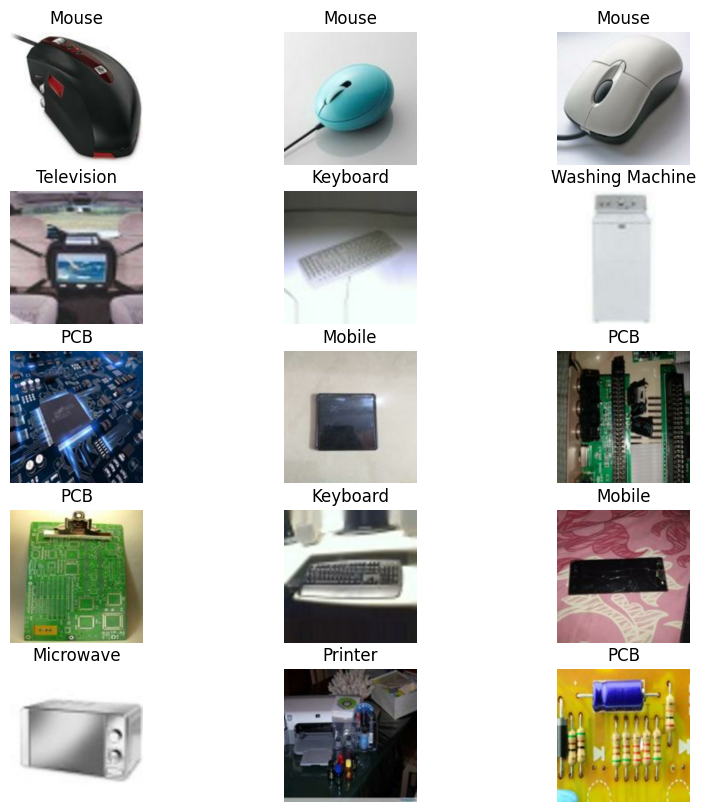

In [8]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(15):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(5, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

🎯 This code helps you visually check if your images and their labels are loading correctly from your dataset.

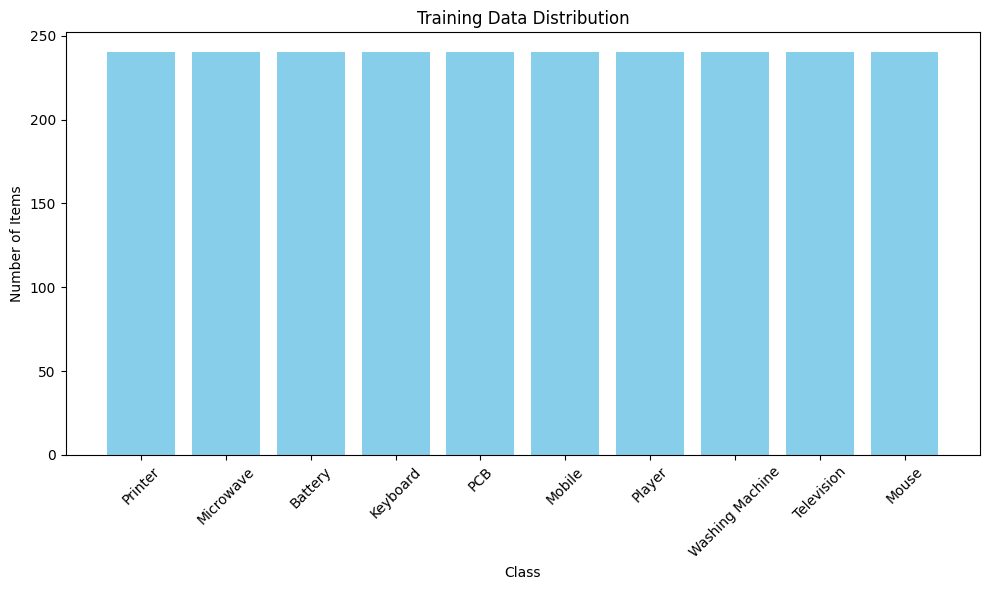

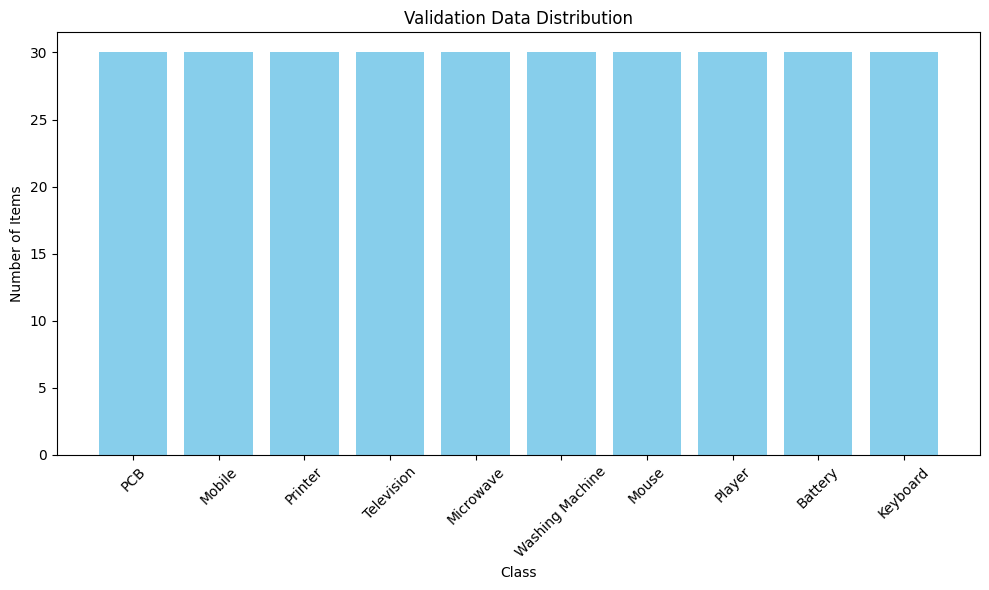

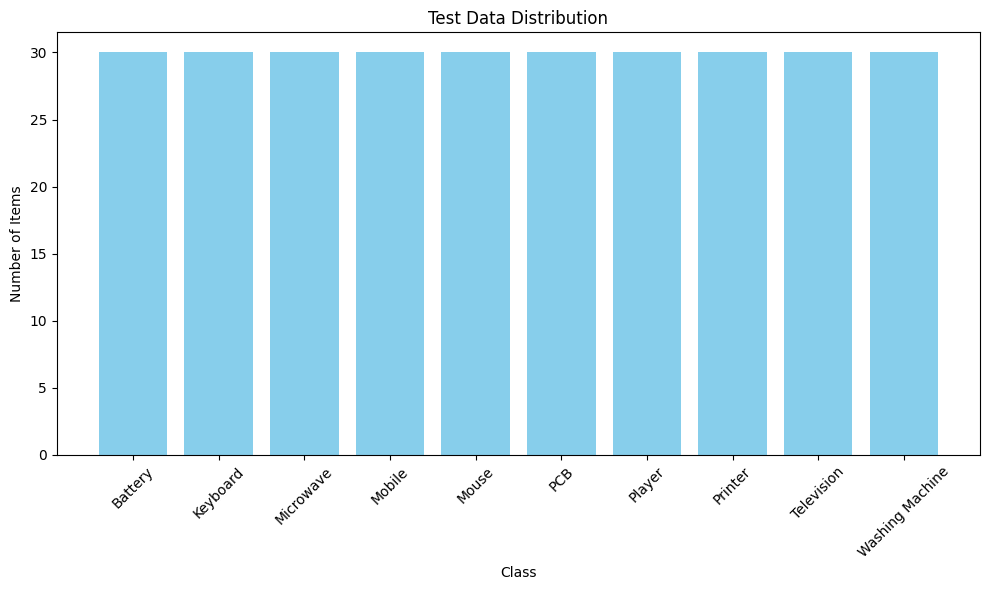

In [9]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class
        # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(dataval, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")



**2. Data Preprocessing / Preparation**

**Use preprocess_input() — for pretrained models only**

In [10]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

datatrain = datatrain.map(lambda x, y: (preprocess_input(x), y))
dataval = dataval.map(lambda x, y: (preprocess_input(x), y))
datatest = datatest.map(lambda x, y: (preprocess_input(x), y))

Since iam using MobileNetV3, which is a pretrained deep learning model, it’s important to prepare your image data in the same way that the model expects. This is done using a special function called preprocess_input(), which is provided by TensorFlow. When images are loaded, their pixel values usually range from 0 to 255, but MobileNetV3 expects these values to be scaled between -1 and 1. The preprocess_input() function automatically handles this conversion. Applying it to your training, validation, and test datasets ensures that the images are in the right format for the model to make accurate predictions. Without this step, the model might not perform well, even if the rest of the code is correct. Therefore, using preprocess_input() is a key part of preparing your image data when working with pretrained models like MobileNetV3.

** Apply Data Augmentation (Only on Training Data)**

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

datatrain = datatrain.map(lambda x, y: (data_augmentation(x, training=True), y))


Teaches model to recognize varied versions of the same image (increases accuracy and robustness).

**3. Model Selection**

In [12]:
# ✅ Step 1: Import the MobileNetV3Small model from Keras applications
from tensorflow.keras.applications import MobileNetV3Small

# ✅ Step 2: Load the MobileNetV3Small model as a base
# We are NOT using the top (final) classification layer because we'll add our own
# Weights='imagenet' means use pretrained weights from the large ImageNet dataset
base_model = MobileNetV3Small(
    input_shape=(224, 224, 3),     # Input image size (height, width, channels=RGB Colours)
    include_top=False,             # Exclude the default dense layers on top(default Classification)
    weights='imagenet'             # Use pretrained weights to avoid training from scratch
)

# ✅ Step 3: Make the whole model trainable (optional but required for fine-tuning)
base_model.trainable = True

# ✅ Step 4: Freeze the first 100 layers (they’ve already learned general patterns)
# This speeds up training and prevents overfitting
for layer in base_model.layers[:10]:
    layer.trainable = False

**Model Training**

In [13]:
# Step 1: Define the input shape for your images
inputs = Input(shape=(224, 224, 3))  # MobileNetV3Large expects 224x224 images

# Step 2: Preprocess input as required by MobileNetV3
x = preprocess_input(inputs)

# Step 3: Load MobileNetV3Large model (pretrained on ImageNet)
base_model = MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Step 4: Freeze the first 100 layers to speed up training and retain learned features
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Step 5: Pass the preprocessed input through the base model
x = base_model(x, training=False)

# Step 6: Add custom classification layers
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)  # 10 classes

# Step 7: Create the full model
model = Model(inputs, outputs)

# Step 8: Compile the model with AdamW optimizer
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


**🔹 Step 1: Define Input Layer**

inputs = Input(shape=(128, 128, 3))

🔍 What it does:

Creates the starting point of your model, where each input is an image of size 128×128 pixels with 3 color channels (RGB).



**🔹 Step 2: Preprocessing Layer**

x = preprocess_input(inputs)

🔍 What it does:

Applies MobileNetV3's required preprocessing — it scales pixel values from [0, 255] to [-1, 1], helping the model perform better.


**🔹 Step 3: Load MobileNetV3 (Pretrained Base Model)**

base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = True

🔍 What it does:

Loads the MobileNetV3Small model:

include_top=False means we’ll build our own classifier.

weights='imagenet' uses already-trained weights from a large dataset.

trainable=True allows fine-tuning of this model.

**🔹 Step 4: Freeze First 100 Layers**

for layer in base_model.layers[:100]:
    layer.trainable = False

🔍 What it does:

Prevents the first 100 layers from being updated during training.
These layers already learned general patterns like edges and shapes.

**🔹 Step 5: Connect Base Model**

x = base_model(x, training=False)

🔍 What it does:

Passes the preprocessed input through MobileNetV3 (except its original classifier).
Now x contains feature-rich representations of the input image.

**🔹 Step 6: Add Custom Classification Head**

x = GlobalAveragePooling2D()(x)

x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)

outputs = Dense(10, activation='softmax')(x)

🔍 What it does:

GlobalAveragePooling2D(): Converts 2D feature maps into 1D by averaging — reduces model size.

Dropout(0.2): Randomly drops 20% of neurons to prevent overfitting.

Dense(128, activation='relu'): A hidden layer to learn features from MobileNet output.

Dense(10, activation='softmax'): Final output layer — predicts probabilities for each of the 10 e-waste classes.

**🔹 Step 7: Create Model**

model = Model(inputs, outputs)

🔍 What it does:

Combines everything (input → base model → custom head) into a complete model using the Functional API.

**🔹 Step 8: Compile the Model**

🔍 What it does:

AdamW: An advanced version of Adam that adds weight decay (L2 regularization) to avoid overfitting and improve generalization.

learning_rate=0.0001: A small learning rate helps the model fine-tune smoothly without overshooting during updates.

weight_decay=1e-5: Applies a penalty to large weights to prevent the model from becoming too complex or overfitting.

loss='sparse_categorical_crossentropy': Used when your labels are integers (0 to 9), not one-hot encoded — ideal for multiclass image classification.

metrics=['accuracy']: Tracks how well the model is predicting correctly during training and validation.



In my updated approach, I switched from the Sequential API to the Functional API because it offers greater flexibility, especially when using pretrained models like MobileNetV3Small. The Functional API allows me to preprocess inputs, freeze specific layers, and design a custom classification head — all with better control and modularity. Unlike Sequential, which simply stacks layers, the Functional API connects each part of the model clearly and allows future upgrades. This helps improve both training speed and accuracy for my e-waste classification task.

I used AdamW optimizer instead of Adam to improve training stability and generalization. AdamW helps prevent overfitting by adding weight decay (L2 regularization), which is especially helpful when fine-tuning a pretrained model like MobileNetV3 on a limited dataset.

I added a Dense(128, activation='relu') layer to improve the model’s ability to learn abstract patterns before final classification. This intermediate dense layer helps the model distinguish between visually similar classes and boosts accuracy. It was not included in the original Sequential model but is an important improvement in the updated Functional API architecture.

**5. Model Tuning and Optimization**

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Stop training if validation loss doesn’t improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)



**Train the model using .fit() with appropriate epochs**

In [15]:
# Set the number of epochs to train the model
epochs = 30

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=dataval,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early_stop]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.2384 - loss: 2.4985 - val_accuracy: 0.6633 - val_loss: 1.0503
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.7205 - loss: 0.8641 - val_accuracy: 0.8600 - val_loss: 0.5426
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.8440 - loss: 0.4924 - val_accuracy: 0.8767 - val_loss: 0.3922
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8983 - loss: 0.3377 - val_accuracy: 0.9133 - val_loss: 0.3164
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9337 - loss: 0.2344 - val_accuracy: 0.9300 - val_loss: 0.2729
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.9534 - loss: 0.1814 - val_accuracy: 0.9467 - val_loss: 0.2229
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9656 - loss: 0.1409 - val_accuracy: 0.9500 - val_loss: 0.1998
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9710 - loss: 0.1067 - val_accuracy: 0.9467 - v

In [27]:
model.summary() # Print the architecture summary of the  model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001,952 (34.34 MB)

 Trainable params: 2,938,474 (11.21 MB)

 Non-trainable params: 186,528 (728.62 KB)

 Optimizer params: 5,876,950 (22.42 MB)

In [28]:
base_model.summary() # Print the architecture summary of the base model

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_18[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_14[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_18[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_15[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,812,000 (10.73 MB)

 Non-trainable params: 184,352 (720.12 KB)

Model Performance Visualization: Accuracy & Loss Trends

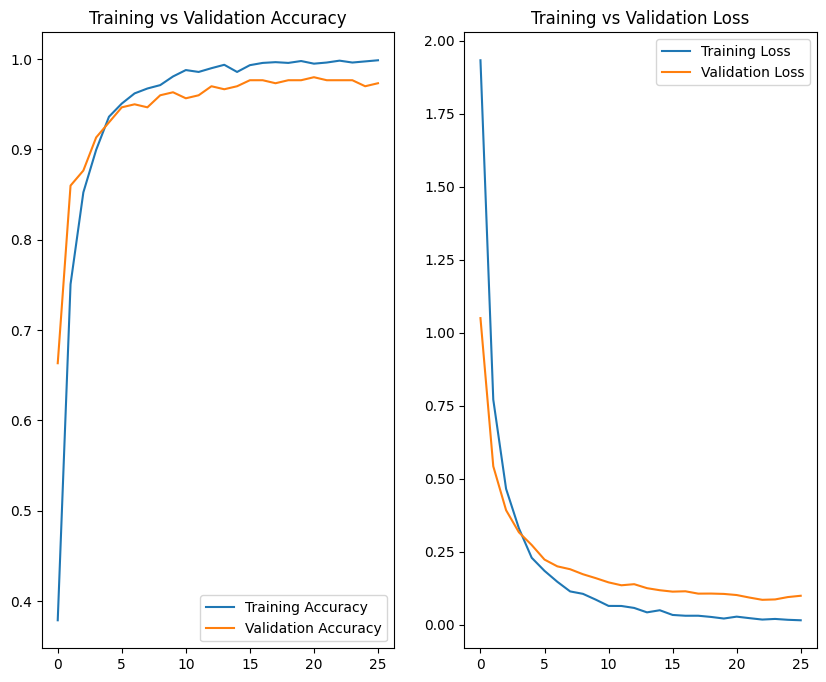

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


**6. Model Evaluation**

In [30]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9727 - loss: 0.1051
Test accuracy is0.9633, Test loss is 0.1278


In [31]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 923ms/step
[[29  0  0  0  0  1  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 28  0  1  1  0  0]
 [ 0  0  0  0  1 29  0  0  0  0]
 [ 0  0  1  0  1  0 28  0  0  0]
 [ 0  0  2  0  0  0  1 27  0  0]
 [ 0  0  2  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      1.00      1.00        30
           2       0.86      1.00      0.92        30
           3       1.00      1.00      1.00        30
           4       0.93      0.93      0.93        30
           5       0.97      0.97      0.97        30
           6       0.93      0.93      0.93        30
           7       0.96      0.90      0.93        30
           8       1.00      0.93      0.97        30
           9       1.00      1.00      1.00        30

    accuracy                   

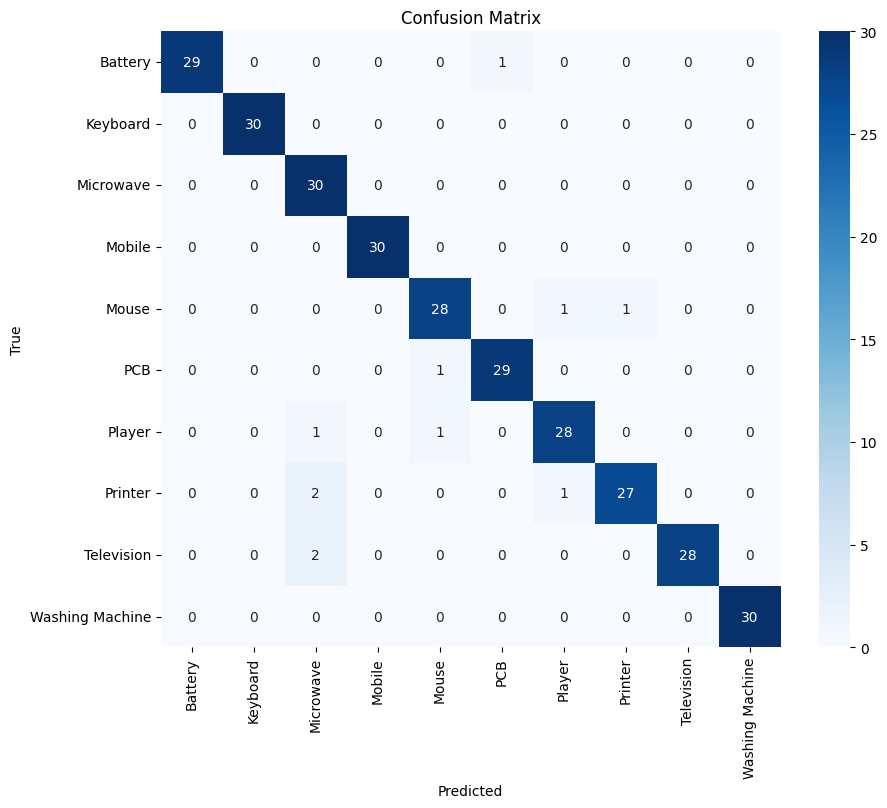

In [33]:

### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


**7. Final Testing and Save the Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


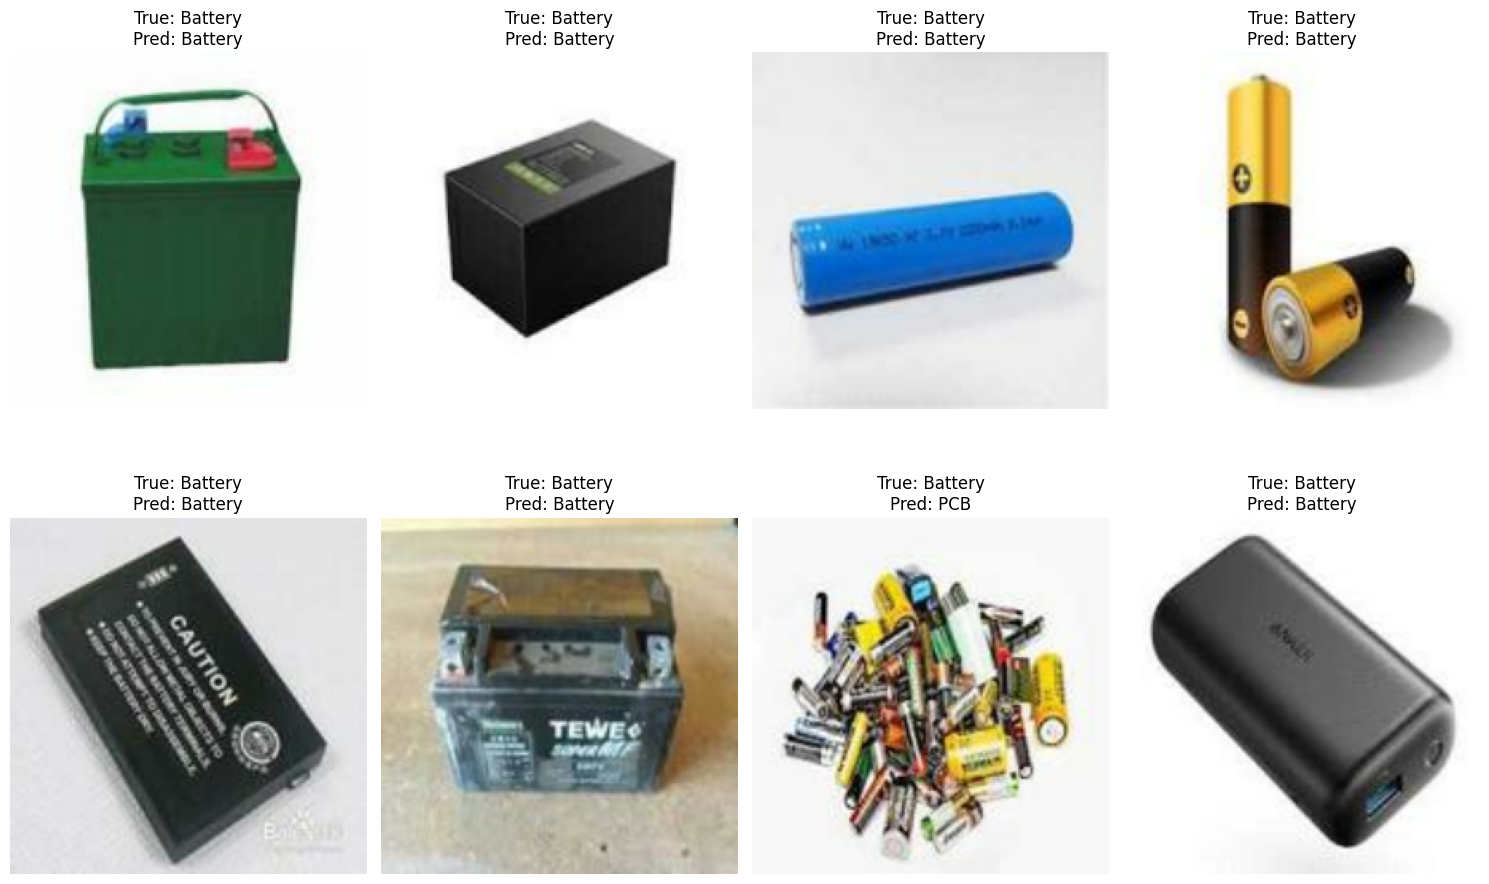

In [34]:
import matplotlib.pyplot as plt

# Use this only if class_names is not available from the dataset object
# class_names = ['battery', 'laptop', 'mobile', 'router', 'keyboard', 'monitor', 'mouse', 'printer']

# Display sample predictions
for images, labels in datatest.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = int(labels[i].numpy())
        predicted_label = int(pred_labels[i].numpy())
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [35]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

**8. Model Deployment**

In [36]:
!pip install gradio

In [37]:
def classify_image(img):
    # Step 1: Resize and convert to RGB
    img = img.resize((224, 224))  # Use (224, 224) if your model was trained with that
    img = img.convert("RGB")

    # Step 2: Convert to array and preprocess
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict
    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    confidence = prediction[0][index]

    # Step 4: Return result
    class_name = class_names[index]
    return f"📦 Predicted: **{class_name}**\n🧠 Confidence: {confidence*100:.2f}%"


In [38]:
import gradio as gr

# Build your interactive interface
demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="📤 Upload an E-Waste Image"),
    outputs=gr.Markdown(label="📢 AI Prediction"),
    title="🔍 E-Waste Image Classifier",
    description="Upload an image of an electronic item (like a laptop, mouse, mobile, etc.), and the AI will predict its category using a MobileNetV3 model trained on e-waste images.",
    theme="default",
    flagging_mode="never"  # ✅ New way to disable flagging
)

# Launch with a public link
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c0ada7af47dfe195e7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
